Episode 0, Total Reward: -0.14146552280271862, Epsilon: 0.995
Episode 1, Total Reward: 0.98884466740692, Epsilon: 0.990025
Episode 2, Total Reward: 3.6757151707856335, Epsilon: 0.985074875
Episode 3, Total Reward: 2.5436322763660426, Epsilon: 0.9801495006250001
Episode 4, Total Reward: 7.496698002441371, Epsilon: 0.9752487531218751
Episode 5, Total Reward: 6.210622887678346, Epsilon: 0.9703725093562657
Episode 6, Total Reward: 5.502369449741672, Epsilon: 0.9655206468094844
Episode 7, Total Reward: 1.8202670128138378, Epsilon: 0.960693043575437
Episode 8, Total Reward: -4.4931097514614065, Epsilon: 0.9558895783575597
Episode 9, Total Reward: 14.98564320444038, Epsilon: 0.9511101304657719
Episode 10, Total Reward: 15.120072470884452, Epsilon: 0.946354579813443
Episode 11, Total Reward: 12.70529811622496, Epsilon: 0.9416228069143757
Episode 12, Total Reward: 12.845675147652623, Epsilon: 0.9369146928798039
Episode 13, Total Reward: 17.04262269378087, Epsilon: 0.9322301194154049
Episode 14,

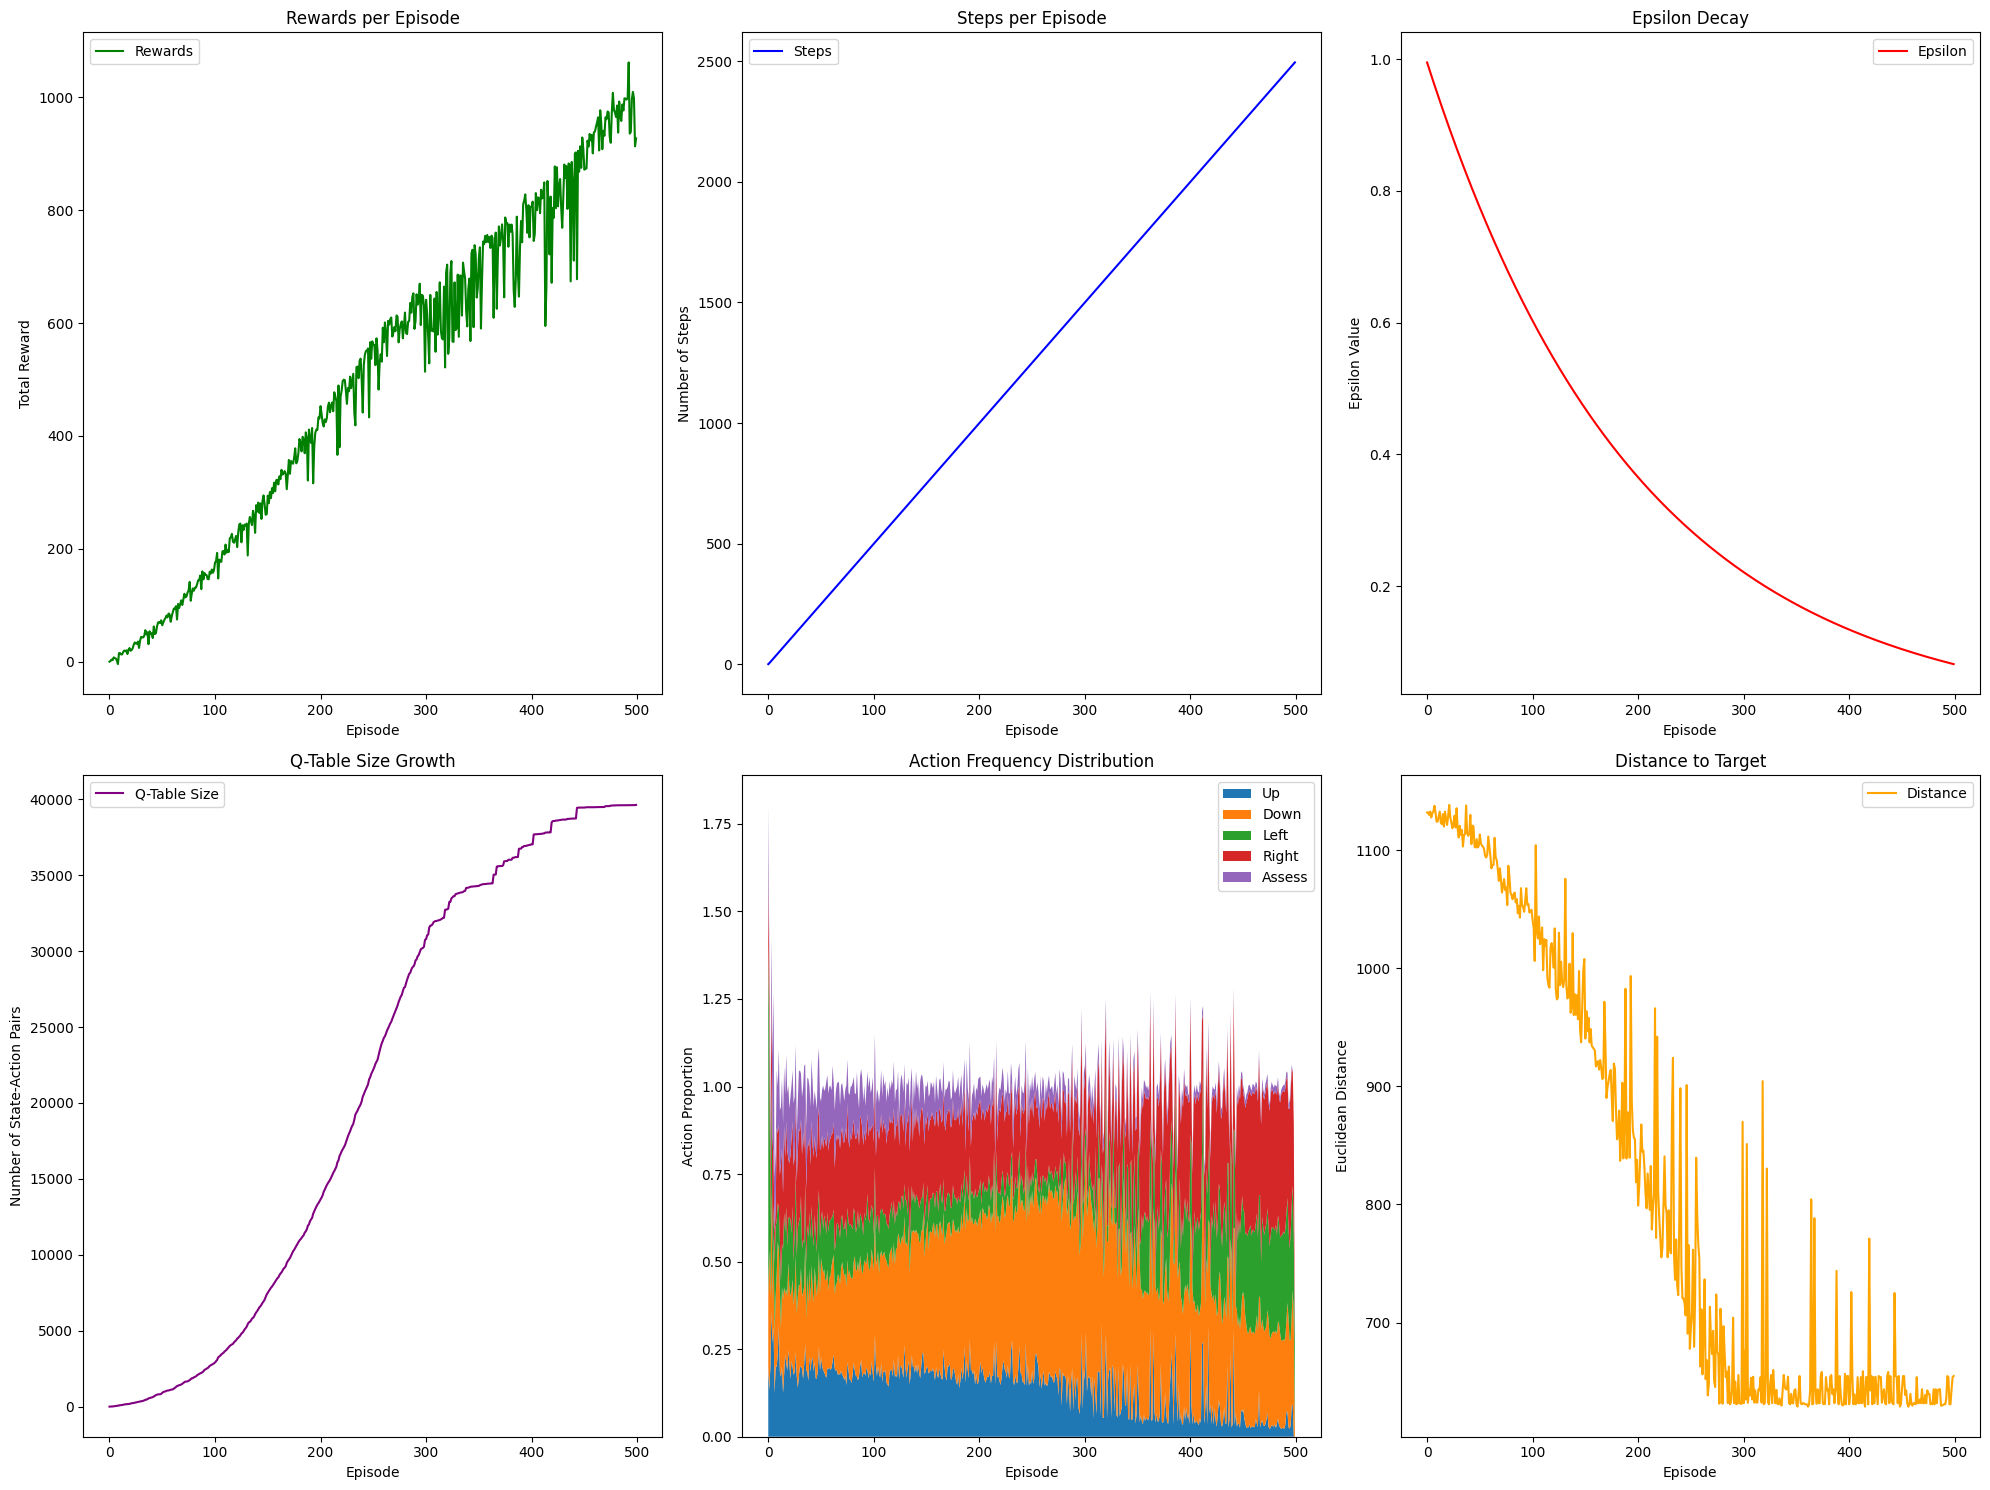

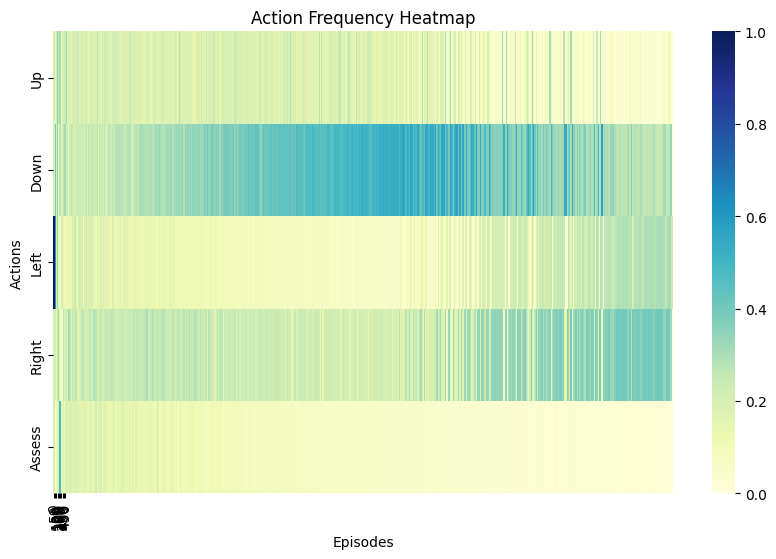

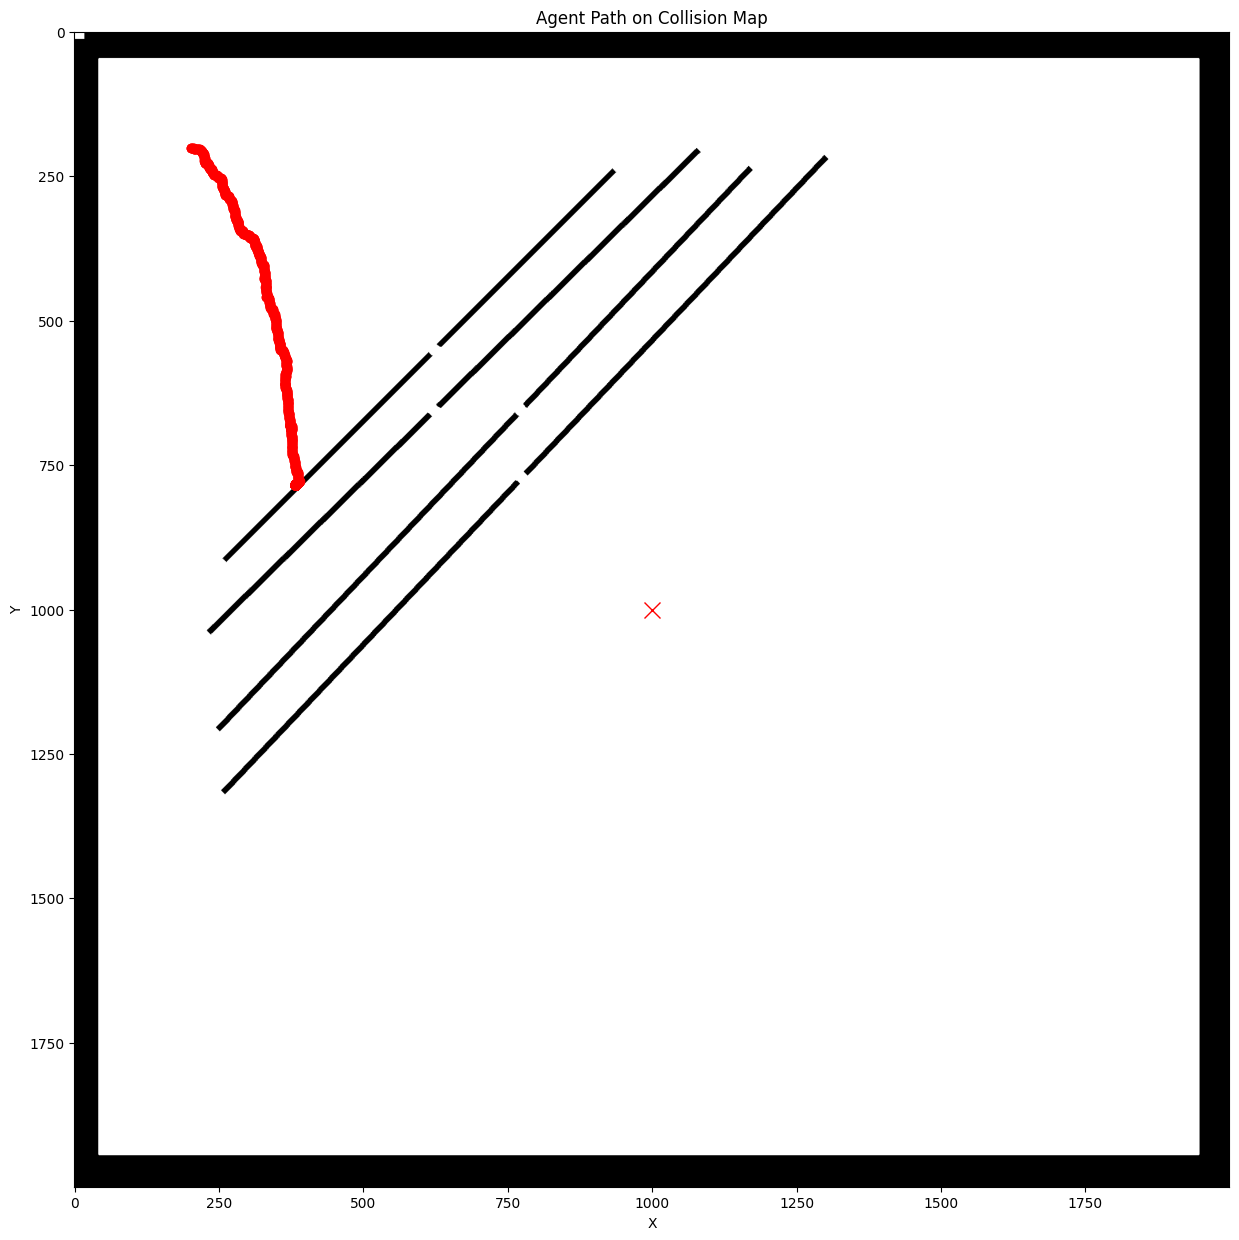

In [1]:
from PIL import Image
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

image = Image.open('simple2.png').convert('1')
collision_map = np.array(image)


class Agent:
    def __init__(self, start_pos):
        self.position = start_pos
        self.previous_position = start_pos
        self.previous_distance = np.linalg.norm(np.array(start_pos) - np.array(target_pos))

    def get_state(self):
        return self.position

    def distance_to_target(self):
        return np.linalg.norm(np.array(self.position) - np.array(target_pos))

    def sense_wall(self, action, map_shape):
        x, y = self.position
        max_x, max_y = map_shape

        if action == "up":
            new_pos = (x - 1, y)
        elif action == "down":
            new_pos = (x + 1, y)
        elif action == "left":
            new_pos = (x, y - 1)
        elif action == "right":
            new_pos = (x, y + 1)
        elif action == "assess":
            return self._check_nearby_walls()
        else:
            return False

        if 0 <= new_pos[0] < max_x and 0 <= new_pos[1] < max_y:
            return collision_map[new_pos[0], new_pos[1]] == 1
        return True

    def _check_nearby_walls(self):

        x, y = self.position
        directions = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

        for dx, dy in directions:
            if 0 <= dx < collision_map.shape[0] and 0 <= dy < collision_map.shape[1]:
                if collision_map[dx, dy] == 1:
                    return True
        return False

    def move(self, action, map_shape):
        x, y = self.position
        max_x, max_y = map_shape

        if action == "up":
            new_pos = (x - 1, y)
        elif action == "down":
            new_pos = (x + 1, y)
        elif action == "left":
            new_pos = (x, y - 1)
        elif action == "right":
            new_pos = (x, y + 1)
        elif action == "assess":
            return
        else:
            return

        # Check if the new position is within the bounds of the map and not a wall
        if max_x > new_pos[0] >= 0 == collision_map[new_pos[0], new_pos[1]] and 0 <= new_pos[1] < max_y:
            self.previous_position = self.position
            self.position = new_pos


class QLearningAgent:
    def __init__(self, action_space, learning_rate=0.1, discount_factor=0.95, epsilon=1.0):
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = 0.995
        self.min_epsilon = 0.01
        self.q_table = {}

    def choose_action(self, state, wall_detected, distance_to_target):
        full_state = (state, wall_detected, round(distance_to_target, 1))

        if full_state not in self.q_table:
            self.q_table[full_state] = {action: 0 for action in self.action_space}

        if random.uniform(0, 1) < self.epsilon:
            action = random.choice(self.action_space)
        else:
            action = self.best_action(full_state)

        return action

    def best_action(self, state):
        """Select the action with the highest Q-value for the given state."""
        if state in self.q_table:
            return max(self.q_table[state], key=self.q_table[state].get)
        return random.choice(self.action_space)

    def update_q_value(self, state, wall_detected, action, reward, next_state, next_wall_detected, distance_to_target,
                       next_distance_to_target):

        full_state = (state, wall_detected, round(distance_to_target, 1))
        full_next_state = (next_state, next_wall_detected, round(next_distance_to_target, 1))

        if full_state not in self.q_table:
            self.q_table[full_state] = {act: 0 for act in self.action_space}

        if full_next_state not in self.q_table:
            self.q_table[full_next_state] = {act: 0 for act in self.action_space}

        # Calculate Q-value update
        old_q_value = self.q_table[full_state][action]
        max_next_q_value = max(self.q_table[full_next_state].values())

        new_q_value = old_q_value + self.learning_rate * (
                reward + self.discount_factor * max_next_q_value - old_q_value
        )

        self.q_table[full_state][action] = new_q_value

    def decay_epsilon(self):
        """Gradually reduce epsilon, ensuring it doesn't go below min_epsilon"""
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)


def reward_function(agent_pos, target_pos, collision_map, previous_distance, wall_in_front,
                    previous_position, current_action, previous_action):
    reward = 0

    distance_to_target = np.linalg.norm(np.array(agent_pos) - np.array(target_pos))

    distance_change = previous_distance - distance_to_target

    if distance_change > 0:
        reward += distance_change
    else:
        reward += distance_change * 0.2

    if wall_in_front:
        if agent_pos != previous_position:
            reward += 1
        elif agent_pos == previous_position:
            reward -= 2

    if collision_map[agent_pos[0], agent_pos[1]] == 1:
        reward -= 10

    if current_action == "assess":
        if wall_in_front:
            reward += 1
    if current_action == "assess":
        if previous_action == "assess":
            reward -= 1

    return reward


class ModelTracker:
    def __init__(self):
        # Tracking metrics
        self.episode_rewards = []
        self.episode_steps = []
        self.epsilon_values = []
        self.q_table_sizes = []
        self.action_frequencies = {
            "up": [],
            "down": [],
            "left": [],
            "right": [],
            "assess": []
        }
        self.distance_to_target = []

    def track_episode(self, episode, total_reward, steps, epsilon, q_table, action_counts, agent_pos, target_pos):
        self.episode_rewards.append(total_reward)
        self.episode_steps.append(steps)
        self.epsilon_values.append(epsilon)
        self.q_table_sizes.append(len(q_table))

        total_actions = sum(action_counts.values())
        for action, count in action_counts.items():
            self.action_frequencies[action].append(count / total_actions if total_actions > 0 else 0)

        distance = np.linalg.norm(np.array(agent_pos) - np.array(target_pos))
        self.distance_to_target.append(distance)

    def plot_analysis(self):
        max_length = max(len(freq) for freq in self.action_frequencies.values())

        padded_frequencies = {
            action: (freq + [0] * (max_length - len(freq)))
            for action, freq in self.action_frequencies.items()
        }

        plt.figure(figsize=(20, 15))

        plt.subplot(2, 3, 1)
        plt.plot(self.episode_rewards, label='Rewards', color='green')
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(self.episode_steps, label='Steps', color='blue')
        plt.title('Steps per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Number of Steps')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(self.epsilon_values, label='Epsilon', color='red')
        plt.title('Epsilon Decay')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon Value')
        plt.legend()

        plt.subplot(2, 3, 4)
        plt.plot(self.q_table_sizes, label='Q-Table Size', color='purple')
        plt.title('Q-Table Size Growth')
        plt.xlabel('Episode')
        plt.ylabel('Number of State-Action Pairs')
        plt.legend()

        plt.subplot(2, 3, 5)
        action_freq_array = np.array([
            padded_frequencies['up'],
            padded_frequencies['down'],
            padded_frequencies['left'],
            padded_frequencies['right'],
            padded_frequencies['assess']
        ])
        plt.stackplot(
            range(len(padded_frequencies['up'])),
            action_freq_array,
            labels=['Up', 'Down', 'Left', 'Right', 'Assess']
        )
        plt.title('Action Frequency Distribution')
        plt.xlabel('Episode')
        plt.ylabel('Action Proportion')
        plt.legend(loc='upper right')

        plt.subplot(2, 3, 6)
        plt.plot(self.distance_to_target, label='Distance', color='orange')
        plt.title('Distance to Target')
        plt.xlabel('Episode')
        plt.ylabel('Euclidean Distance')
        plt.legend()

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.heatmap(
            action_freq_array,
            cmap='YlGnBu',
            xticklabels=range(0, len(action_freq_array[0]), 50),
            yticklabels=['Up', 'Down', 'Left', 'Right', 'Assess']  # Added Assess to heatmap
        )
        plt.title('Action Frequency Heatmap')
        plt.xlabel('Episodes')
        plt.ylabel('Actions')
        plt.show()


class PathfindingEnv:
    def __init__(self, collision_map, target_pos):
        self.collision_map = collision_map
        self.target_pos = target_pos
        self.agent = Agent(start_pos=(200, 200))
        self.max_steps = None
        self.current_steps = 0
        self.episode_path = []

    def reset(self, max_steps):
        self.agent = Agent(start_pos=(200, 200))
        self.current_steps = 0
        self.max_steps = max_steps
        self.episode_path = []
        return self.agent.position

    def step(self, action, previous_action):
        wall_in_front = self.agent.sense_wall(action, self.collision_map.shape)

        previous_position = self.agent.position

        self.agent.move(action, self.collision_map.shape)

        if action != "assess":
            self.episode_path.append(self.agent.position)

        self.current_steps += 1

        reward = reward_function(self.agent.position, self.target_pos, self.collision_map,
                                 self.agent.previous_distance, wall_in_front, previous_position,
                                 action, previous_action)

        self.agent.previous_distance = np.linalg.norm(np.array(self.agent.position) - np.array(self.target_pos))

        if self.agent.position == self.target_pos:
            return self.agent.position, reward, True
        elif self.current_steps >= self.max_steps:
            return self.agent.position, reward, True
        return self.agent.position, reward, False


map_shape = collision_map.shape
target_pos = (map_shape[0] // 2, map_shape[1] // 2)

env = PathfindingEnv(collision_map, target_pos=target_pos)
agent = QLearningAgent(action_space=["up", "down", "left", "right", "assess"])
rewards_list = []
epsilon_list = []

model_tracker = ModelTracker()

for episode in range(500):
    max_steps = min(episode * 5, 5000)
    state = env.reset(max_steps=max_steps)
    done = False
    total_reward = 0
    action = None
    previous_action = None
    distance_to_target = 0

    action_counts = defaultdict(int)

    while not done:
        state = env.agent.get_state()  # Current state
        wall_detected = env.agent.sense_wall(action, map_shape) if action else False
        distance_to_target = env.agent.distance_to_target()

        action = agent.choose_action(state, wall_detected, distance_to_target)
        action_counts[action] += 1

        next_state, reward, done = env.step(action, previous_action)

        next_wall_detected = env.agent.sense_wall(action, map_shape)
        next_distance_to_target = env.agent.distance_to_target()

        agent.update_q_value(state, wall_detected, action, reward, next_state, next_wall_detected, distance_to_target,
                             next_distance_to_target)

        state = next_state
        previous_action = action

        total_reward += reward

    agent.decay_epsilon()

    model_tracker.track_episode(
        episode,
        total_reward,
        env.current_steps,
        agent.epsilon,
        agent.q_table,
        action_counts,
        env.agent.position,
        target_pos
    )

    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

model_tracker.plot_analysis()

plt.figure(figsize=(15, 15))
plt.imshow(collision_map, cmap='binary')
plt.plot([pos[1] for pos in env.episode_path], [pos[0] for pos in env.episode_path], '-o', color='r')
plt.plot(target_pos[1], target_pos[0], 'rx', markersize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Agent Path on Collision Map')
plt.show()
